In [1]:
import numpy as np 
import pandas as pd 
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from PIL import Image
import matplotlib.pyplot as plt

import matplotlib.patches as patches
import os


In [2]:
image_ids = os.listdir('../input/demo-test-images/demo_data')
image_ids

['sample2.jpg', 'sample1.jpg', 'sample3.jpg']

In [13]:
# Dataset class for Training - 90%of data
class CustomDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files
        self.img_ids = range(len(os.listdir('../input/demo-test-images/demo_data/')))
    def __getitem__(self, idx):
        """Gives the image and target for each image id

        Args:
            idx: (int) image_id
        Returns:
            (torch.tensor) image of shape (c,h,w)
            (dict) target :{'boxes':[[xmin,ymin,xmax,ymax],.....],'labels':[1,2,1,...],'image_id','1'}
        """
        image_name= image_ids[idx]
        img_path = os.path.join("../input/demo-test-images/demo_data", image_name)
        img = Image.open(img_path).convert("RGB")
        
        if self.transforms is not None:
            img = self.transforms(img)
        return img

    def __len__(self):
        return len(self.img_ids)
    
#preprocessing transformation      
data_transform = transforms.Compose([
        transforms.ToTensor(), ])
# #batch processing
# def collate_fn(batch):
#     return tuple(zip(*batch))

# Train Dataset loader for pytorch model
train_dataset = CustomDataset(data_transform)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1)

In [4]:
# for FasterRCNN with FPN model
def get_model(num_classes):
    """ Creates the model for training

    Args:
        num_classes: (int) Number of classes in the dataset
       
    Returns:
        (model) pytorch model
    """
    # load an model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


model = get_model(3)
#devic info (GPU/CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#Load the trained model
model.load_state_dict(torch.load('../input/trained-frcnn-fpn-model/fasterrcnn_resnet50_fpn_100epochs.pth'))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

<All keys matched successfully>

In [23]:

def plot_image(img_tensor, annotation):
    """Plots the groundtruth and prediction.

    Args:
        img_tensor: (tensor) original image
        annotation: (dict) {'boxes':[[....]],'labels':[1,2,1...],'scores':[0.8,0.99,011....]} prediction from the model
    Returns:
        (ax) plot with image and bounding boxes of prediction
    """
    fig,ax = plt.subplots(figsize=(15,15))
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box, label, score in zip(annotation["boxes"],annotation['labels'],annotation['scores'] ):
        if score>0.5:
            xmin, ymin, xmax, ymax = box
            if label.cpu()==1:
                color='r'
            else:
                color='b'

            # Create a Rectangle patch
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor=color,facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)
    ax.set_title('Prediction')
    plt.show()

In [17]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

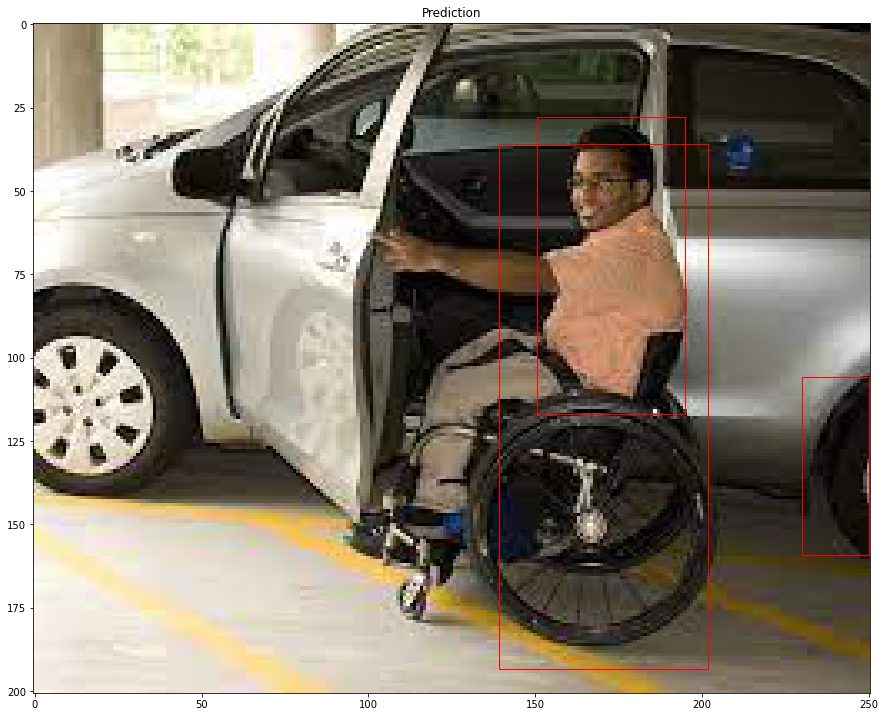

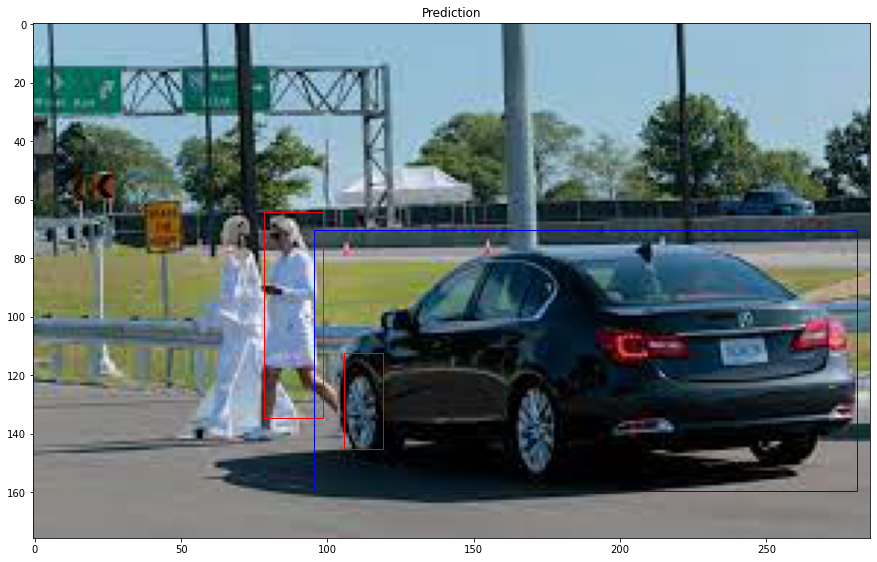

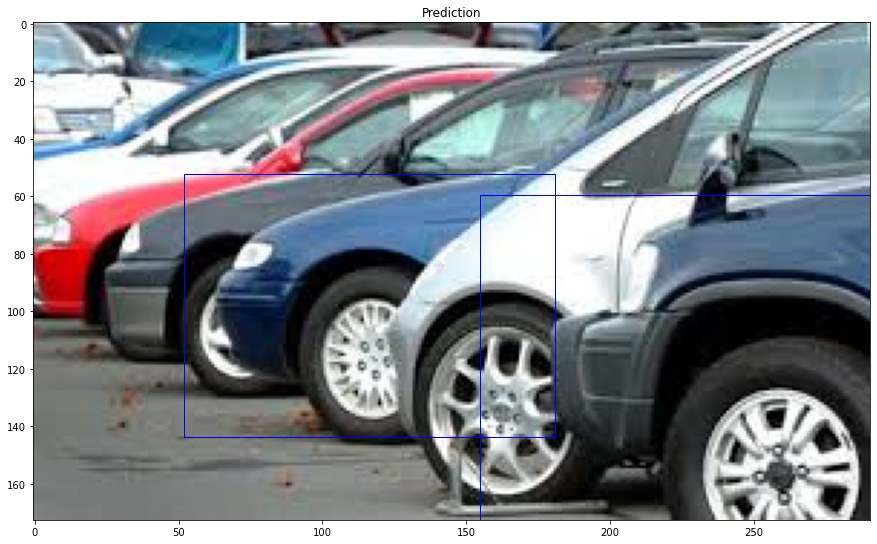

In [25]:
for imgs in train_data_loader:
    imgs = list(img.to(device) for img in imgs)
    model.eval()
    preds = model(imgs)
    plot_image(imgs[0],preds[0])
    
    

---